In [1]:
import os
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-ihg_lzyf because the default path (/home/upbeat_northcutt/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
with open('./pickle_files/embeddings_inds_test_imdb.pkl', 'rb') as f:
    embeddings_imdb_test = pickle.load(f)

with open('./pickle_files/logits_inds_test_imdb.pkl', 'rb') as f:
    logits_imdb_test = pickle.load(f)


In [3]:
with open('./pickle_files/embeddings_inds_train_imdb.pkl', 'rb') as f:
    embeddings_imdb_train = pickle.load(f)

with open('./pickle_files/logits_inds_train_imdb.pkl', 'rb') as f:
    logits_imdb_train = pickle.load(f)

In [4]:
ood_embeddings = []
ood_logits = []
ood_dict = {}

for filename in [el for el in os.listdir('./pickle_files') if el.startswith('embeddings_ood_test_')]:

    ds_name = filename.split('_')[-1].split('.')[0]
    values = {}

    with open('./pickle_files/'+filename, 'rb') as f:
        embeddings = pickle.load(f)
    ood_embeddings += embeddings

    values['embeddings'] = embeddings

    with open(f'./pickle_files/logits_ood_test_{ds_name}.pkl', 'rb') as f:
        logits = pickle.load(f)
    ood_logits += logits

    values['logits'] = logits

    ood_dict[ds_name] = values 

In [5]:
embeddings_imdb_test = torch.cat(embeddings_imdb_test).numpy()
logits_imdb_test = torch.cat(logits_imdb_test).numpy()

In [6]:
def get_predicted_indices(l, logits):
    return np.where(np.argmax(logits, axis=-1)==l)

In [7]:
embeddings_imdb_test_distrib  = {l: embeddings_imdb_test[get_predicted_indices(l, logits_imdb_test)] for l in range(logits_imdb_test.shape[1])}
logit_test_distrib  = {l: logits_imdb_test[get_predicted_indices(l, logits_imdb_test)] for l in range(logits_imdb_test.shape[1])}

In [8]:
embeddings_imdb_train = torch.cat(embeddings_imdb_train).numpy()
logits_imdb_train = torch.cat(logits_imdb_train).numpy()

embeddings_imdb_train_distrib  = {l: embeddings_imdb_train[get_predicted_indices(l, logits_imdb_train)] for l in range(logits_imdb_train.shape[1])}
logit_train_distrib  = {l: logits_imdb_train[get_predicted_indices(l, logits_imdb_train)] for l in range(logits_imdb_train.shape[1])}


In [9]:
# Aggregation per ood dataset
for ds_dict in ood_dict.values():
    for k, v in ds_dict.items():
        ds_dict[k] = torch.cat(v).numpy()
        
    ds_dict['ood_embeddings_distrib']  = {l: ds_dict['embeddings'][get_predicted_indices(l, ds_dict['logits'])] for l in range(ds_dict['logits'].shape[1])}
    ds_dict['ood_logits_distrib']  = {l: ds_dict['logits'][get_predicted_indices(l, ds_dict['logits'])] for l in range(ds_dict['logits'].shape[1])}

In [10]:
from ood_detector import OODDetector
from sklearn.metrics import average_precision_score, roc_auc_score
import seaborn as sns

In [11]:
from utils.my_utils import softmax
from sklearn.metrics import average_precision_score

def plot_score_distrib_non_prediction_dependant(metric):

    clf = OODDetector(
            similarity_measure=metric,
            base_distrib=logits_imdb_train,
            T=10
         ).fit() 

    scores=[]
    weights=[]
    for ds_name,ood_ds in ood_dict.items():
        y_score_tot = []
        y_true_tot = []
        score_per_ds = []
        
        y_true = np.concatenate((np.zeros(logits_imdb_test.shape[0]),np.ones(ood_ds['logits'].shape[0])))
        X = np.concatenate((logits_imdb_test,ood_ds['logits']))
        y_score = clf.compute_similarity(X).flatten()
        auc_score = roc_auc_score(y_true=y_true, y_score=y_score)

        aupr_in = average_precision_score(y_true, y_score, pos_label=0)
        aupr_out = average_precision_score(y_true, y_score, pos_label=1)
        
        scores.append([auc_score, aupr_in, aupr_out])
        weights.append(len(y_true))



        bins_width = (np.histogram(y_score[y_true==1])[1][3]-np.histogram(y_score[y_true==1])[1][2])/2
        sns.histplot(y_score[y_true==0], label='IN-DS', kde=True, stat='probability', color='skyblue', binwidth=bins_width, line_kws={"lw":3})
        sns.histplot(y_score[y_true==1], label='OOD-DS', kde=True, stat='probability', color='red', binwidth=bins_width, line_kws={"lw":3})
        avg = scores[-1]
        plt.title(f"auroc : {avg[0]:.3f}, aupr-in : {avg[1]:.3f}, aupr-out : {avg[2]:.3f}")

        plt.suptitle(ds_name + f' - {clf.similarity_measure}')
        plt.legend()
        plt.savefig(f'./figures/{clf.similarity_measure}_{ds_name}.png')
        plt.show()

    scores, weights = np.array(scores), np.array(weights)/(np.sum(weights))
    print(f" Weighted mean {scores.T@weights}")
    print(f"Mean {np.mean(scores, axis=0)}")
    

In [12]:
def plot_score_distrib_prediction_dependant(metric, aggregation_function = None, use_AI_IRW=True):

    clfs = { i : OODDetector(
            similarity_measure=metric,
            base_distrib=embeddings_imdb_train_distrib[i],
            aggregation_function = aggregation_function,
            use_AI_IRW = use_AI_IRW
         ).fit() for i in (0,1) }

    scores=[]
    weights=[]
    for ds_name,ood_ds in ood_dict.items():
        y_score_tot = []
        y_true_tot = []
        scores = []
        
        for i in [0,1]:
            clf = clfs[i]
            y_true = np.concatenate((np.zeros(embeddings_imdb_test_distrib[i].shape[0]),np.ones(ood_ds['ood_embeddings_distrib'][i].shape[0])))
            X = np.concatenate((embeddings_imdb_test_distrib[i],ood_ds['ood_embeddings_distrib'][i]))
            X = aggregation_function(X)
            #aggregate latent representations
            y_score = clf.compute_similarity(X).flatten()
            y_score_tot.append(y_score)
            y_true_tot.append(y_true)


        y_score_tot = np.concatenate(y_score_tot)
        y_true_tot = np.concatenate(y_true_tot)
        auc_score = roc_auc_score(y_true=y_true_tot, y_score=y_score_tot)
        aupr_in = average_precision_score(y_true_tot, y_score_tot, pos_label=0)
        aupr_out = average_precision_score(y_true_tot, y_score_tot, pos_label=1)
        
        scores.append([auc_score, aupr_in, aupr_out])
        weights.append(len(y_true_tot))


        
        bins_width = (np.histogram(y_score_tot[y_true_tot==1])[1][3]-np.histogram(y_score_tot[y_true_tot==1])[1][2])/2
        sns.histplot(y_score_tot[y_true_tot==0], label='IN-DS', kde=True, stat='probability', color='skyblue', binwidth=bins_width, line_kws={"lw":3})
        sns.histplot(y_score_tot[y_true_tot==1], label='OOD-DS', kde=True, stat='probability', color='red', binwidth=bins_width, line_kws={"lw":3})
        avg = scores[-1]
        plt.title(f"auroc : {avg[0]:.3f}, aupr-in : {avg[1]:.3f}, aupr-out : {avg[2]:.3f}")

        plt.suptitle(ds_name + f' - {clf.similarity_measure}')
        plt.legend()
        plt.savefig(f'./figures/{clf.similarity_measure}_{ds_name}.png')
        plt.show()

        plt.show()


    
    

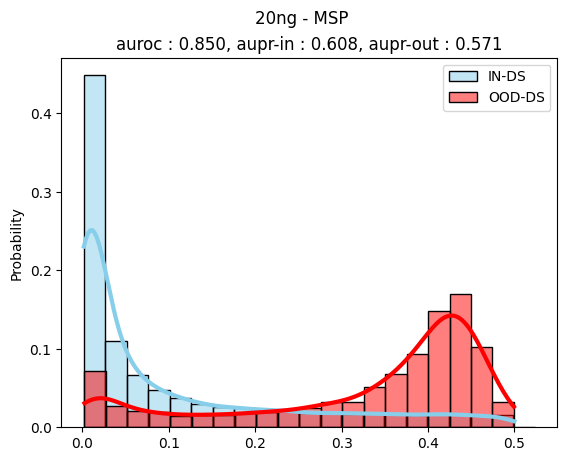

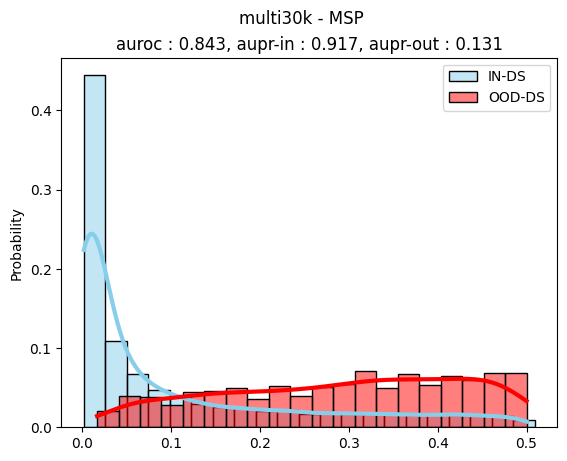

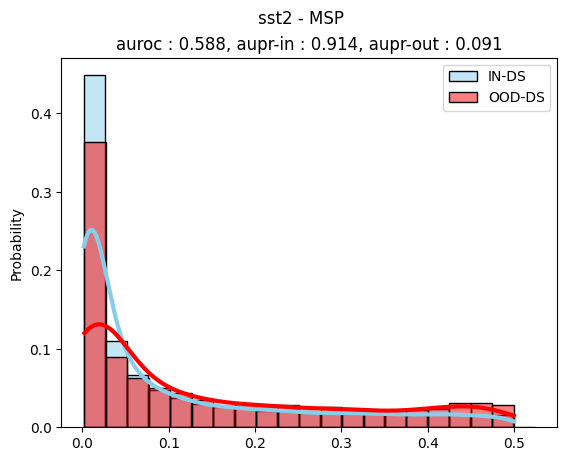

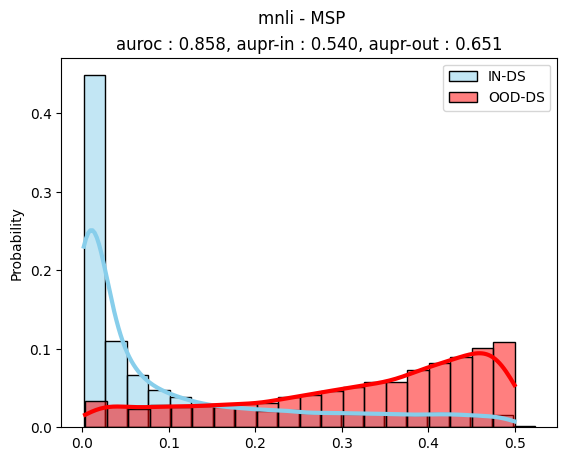

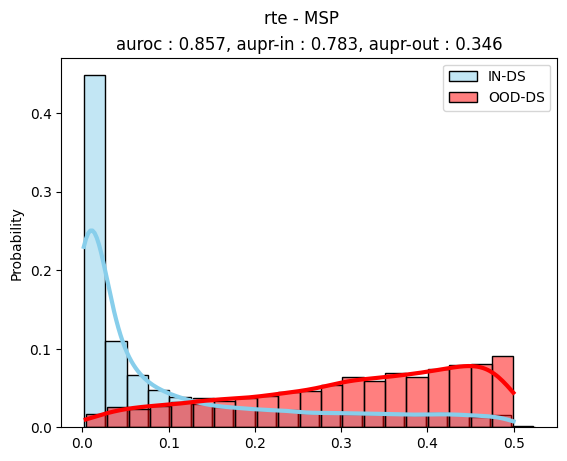

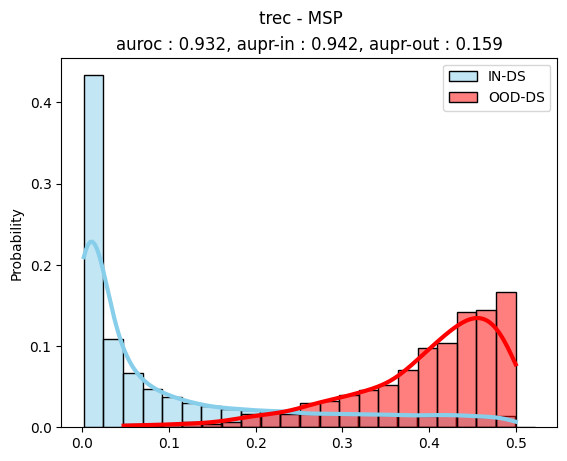

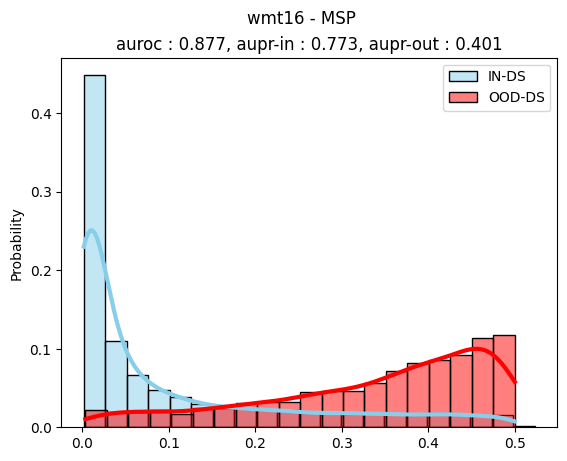

 Weighted mean [0.83083604 0.76639884 0.35708994]
Mean [0.82937867 0.7825845  0.33551427]


In [72]:
plot_score_distrib_non_prediction_dependant('MSP')

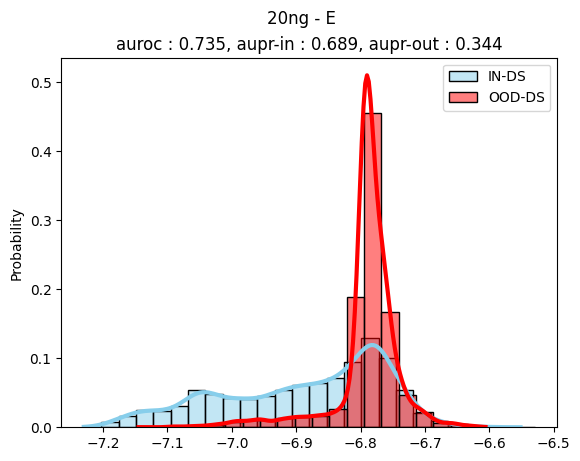

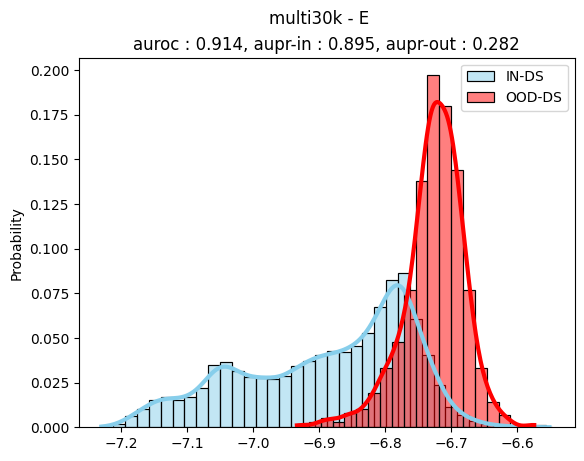

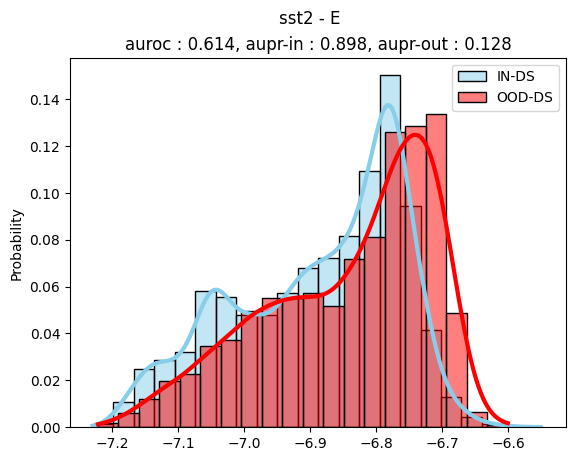

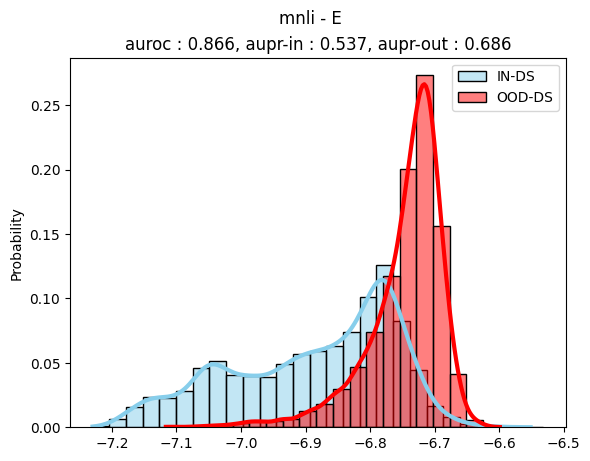

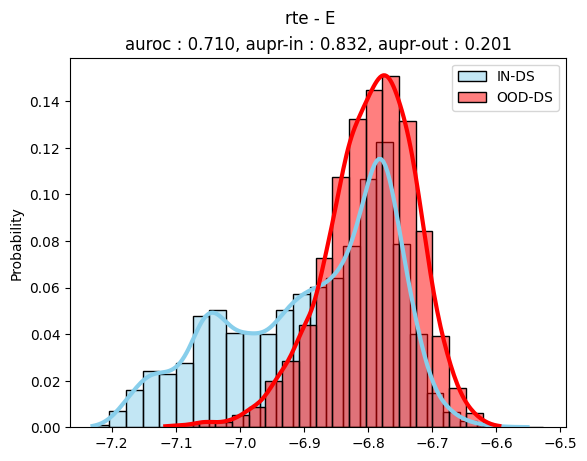

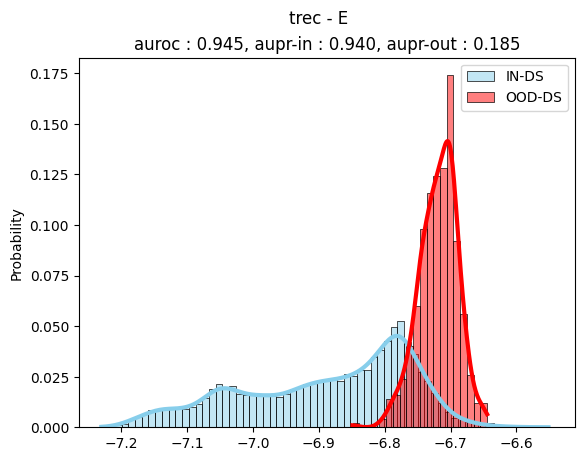

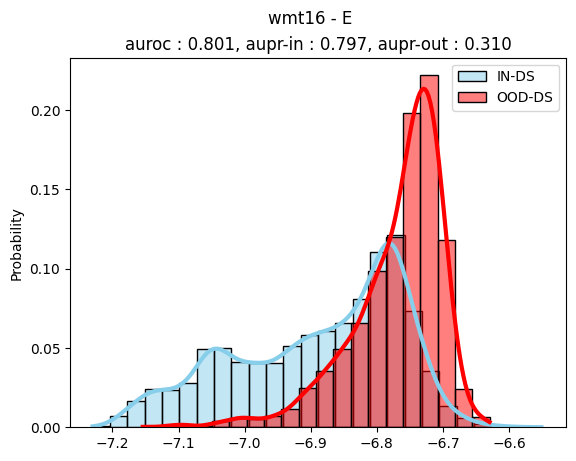

 Weighted mean [0.79685326 0.78373866 0.32169242]
Mean [0.79787859 0.79830194 0.3052435 ]


In [14]:
plot_score_distrib_non_prediction_dependant('E')

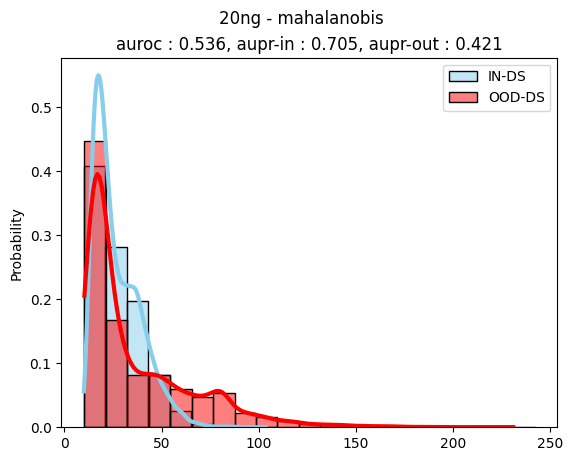

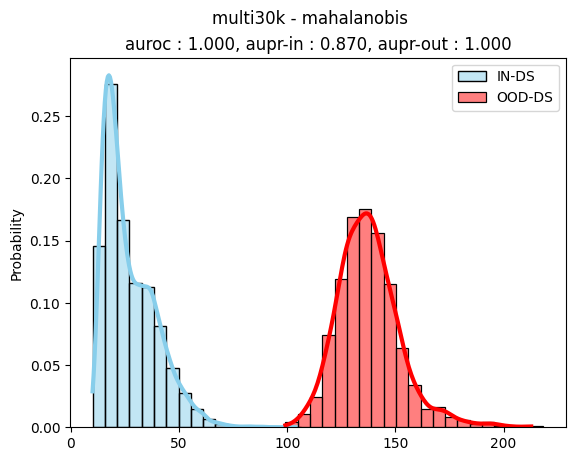

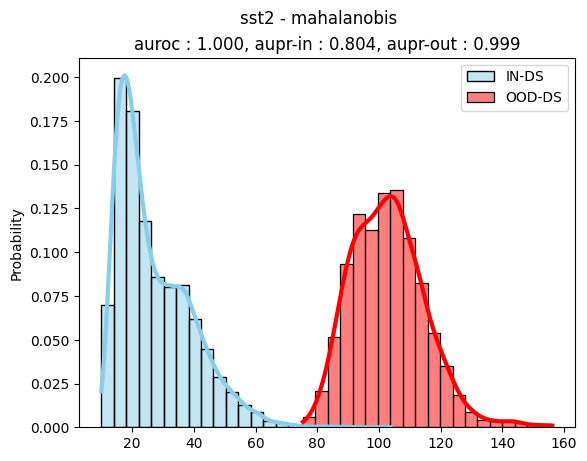

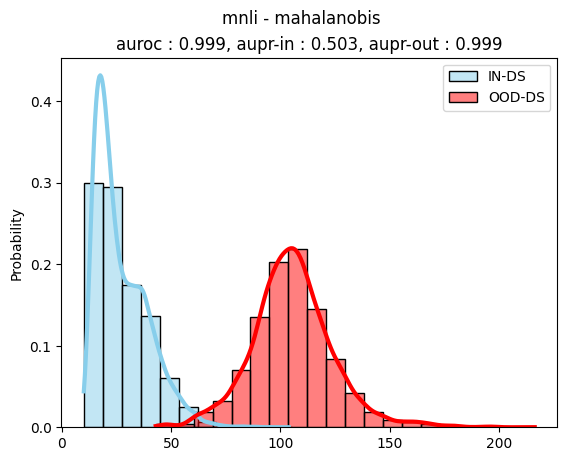

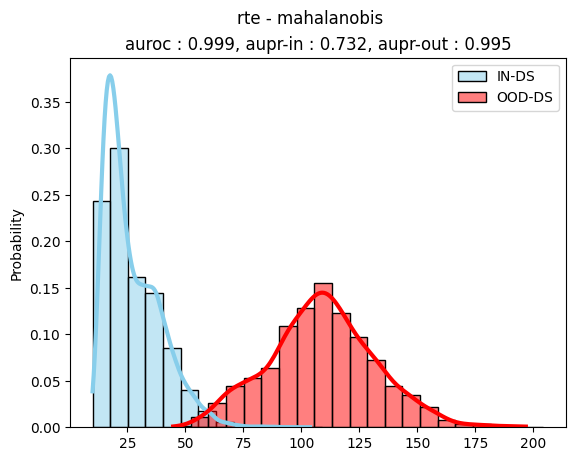

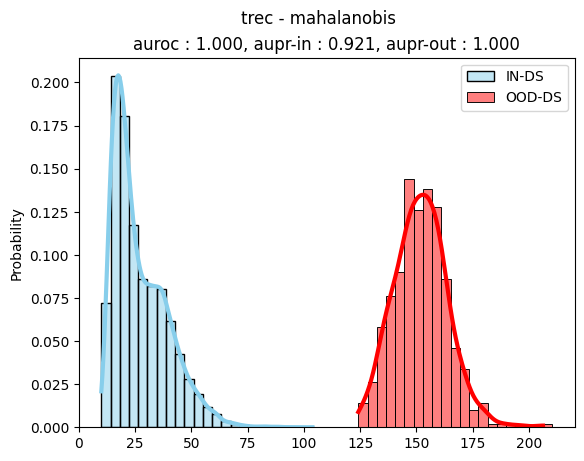

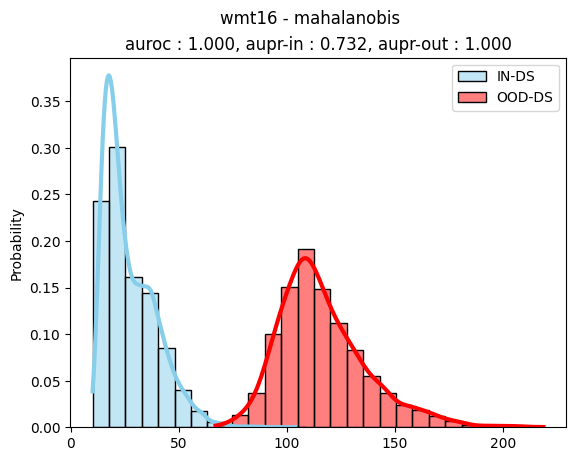

In [18]:
plot_score_distrib_prediction_dependant('mahalanobis',aggregation_function = lambda x : np.mean(x,axis=-1))

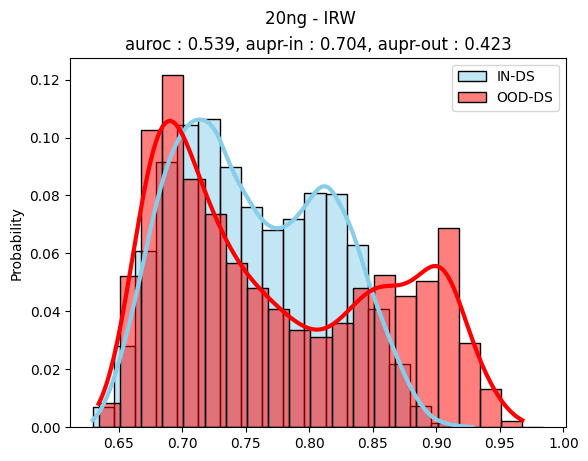

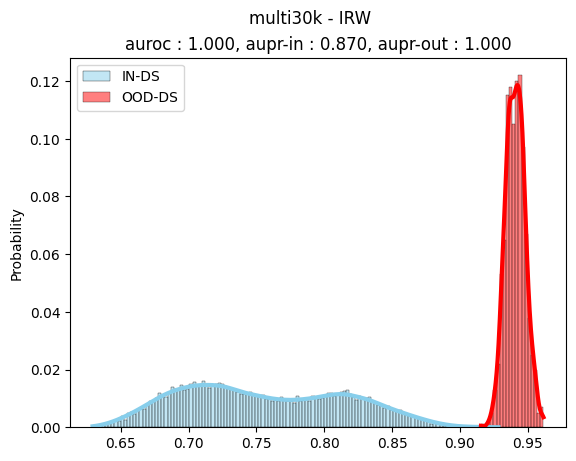

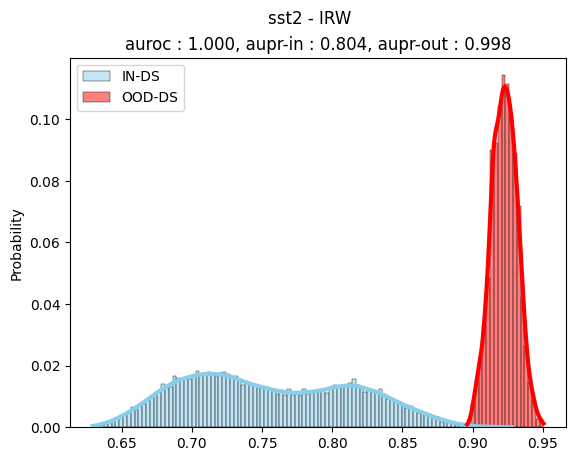

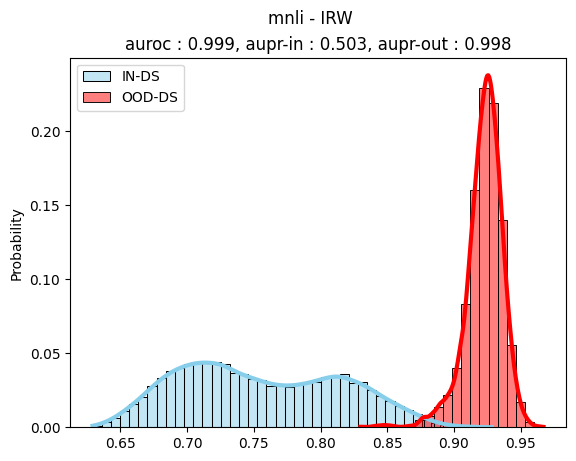

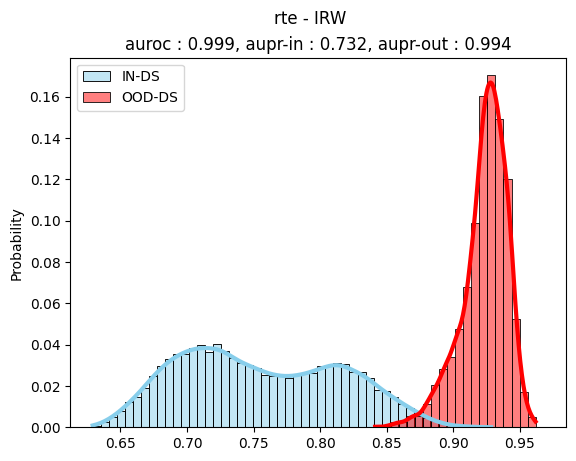

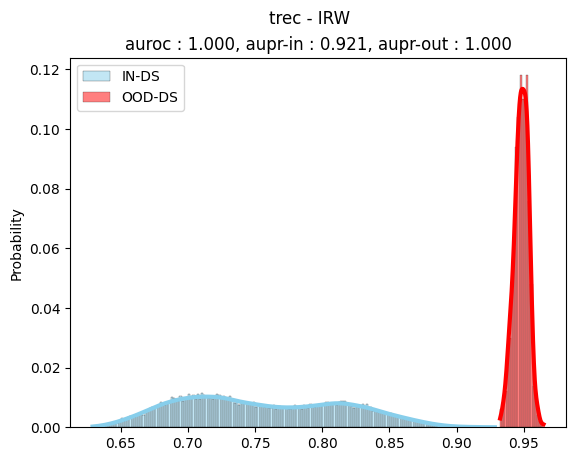

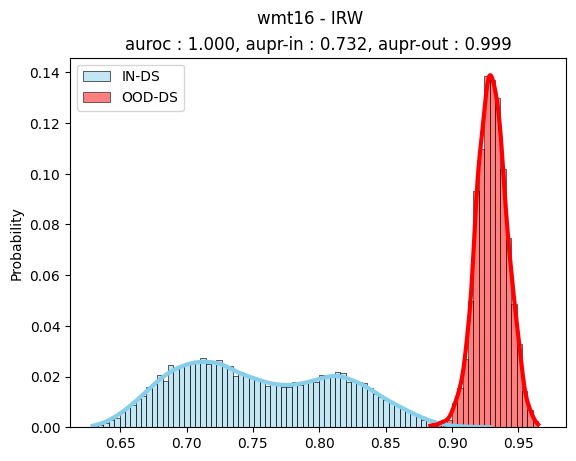

In [19]:
plot_score_distrib_prediction_dependant('IRW',aggregation_function = lambda x : np.mean(x,axis=-1))

In [16]:
def keep_logits(X):
    return X[:,:,-1]

In [13]:
from utils.my_utils import softmax
def aggregate_softmax(X):
    return softmax(X[:,:,-1])

In [19]:
def power_mean(X, p):
    power_sum = np.sum(np.power(X, p), axis=-1)
    power_mean = np.power(power_sum / X.shape[0], 1/p)
    
    return power_mean

def power_mean_wrapper(p):
    return lambda x :  power_mean(x,p)

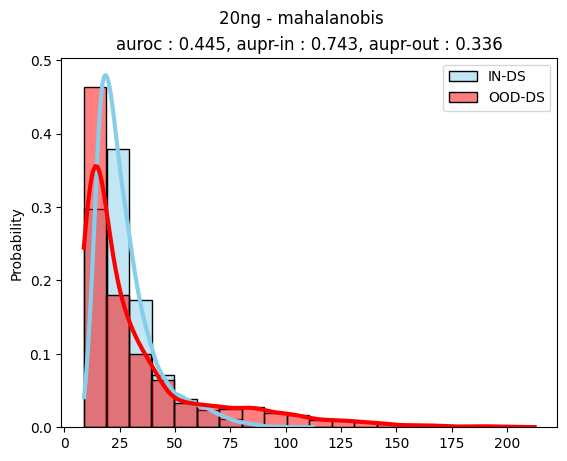

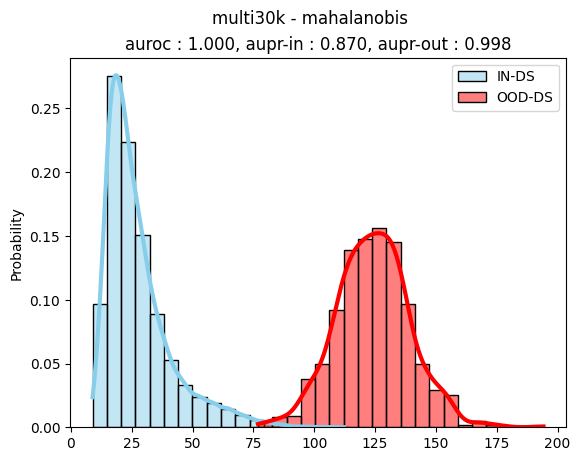

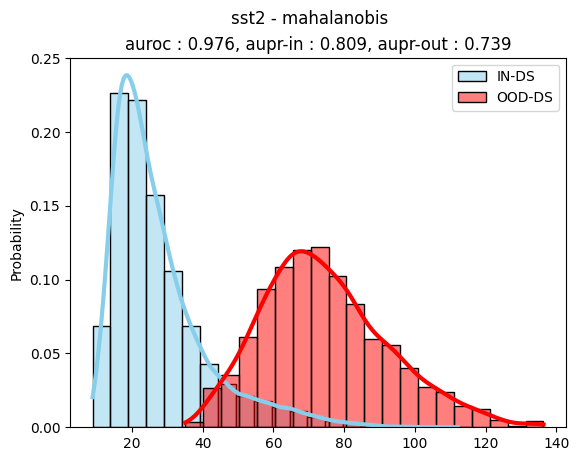

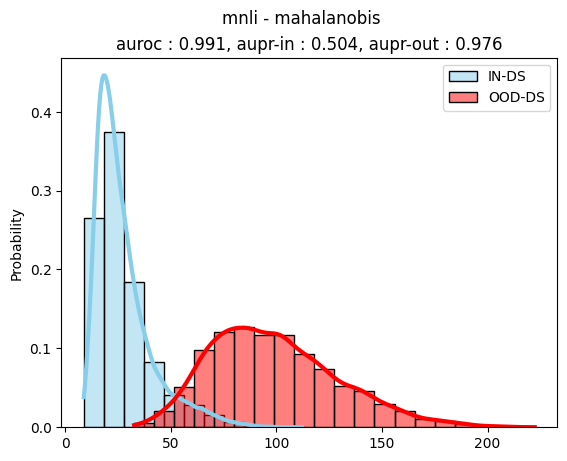

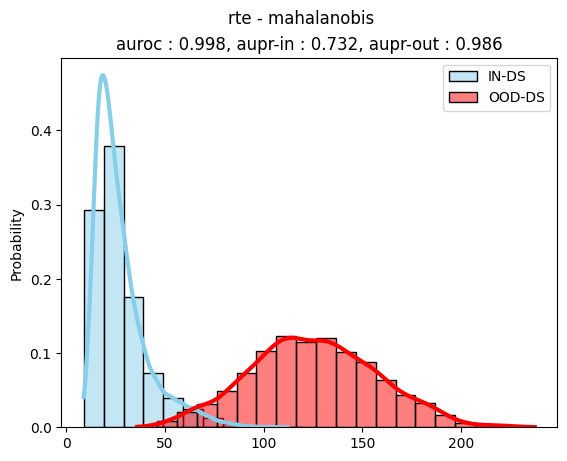

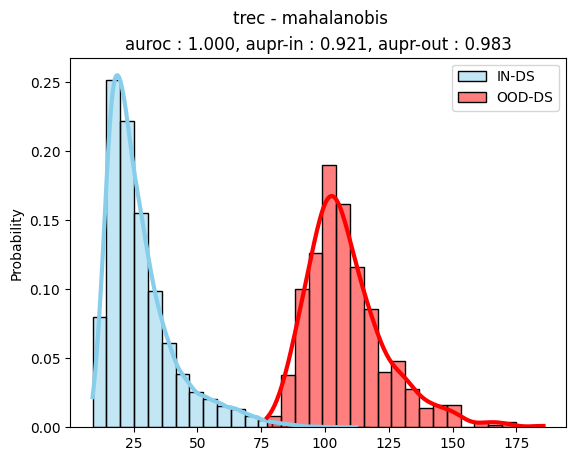

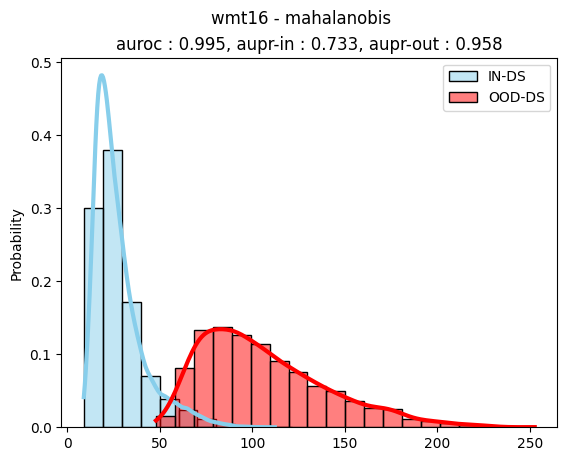

In [14]:
plot_score_distrib_prediction_dependant('mahalanobis',aggregation_function=keep_logits)

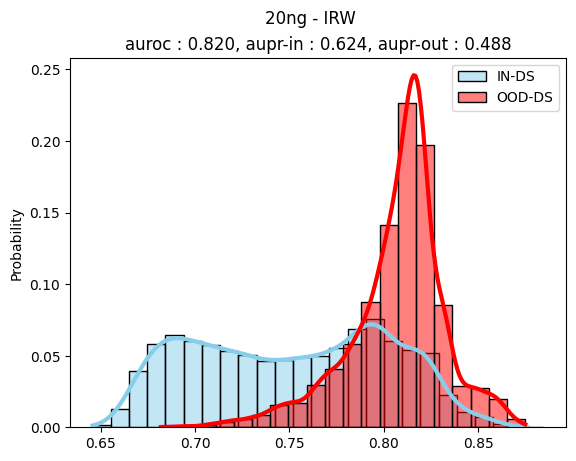

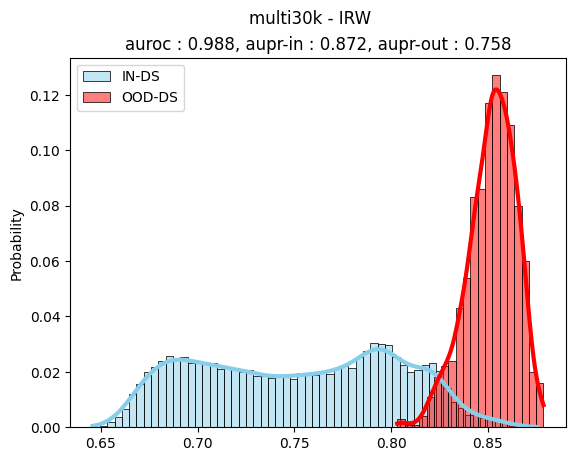

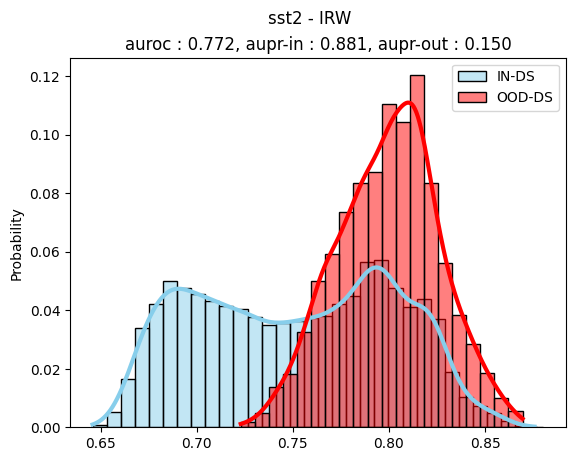

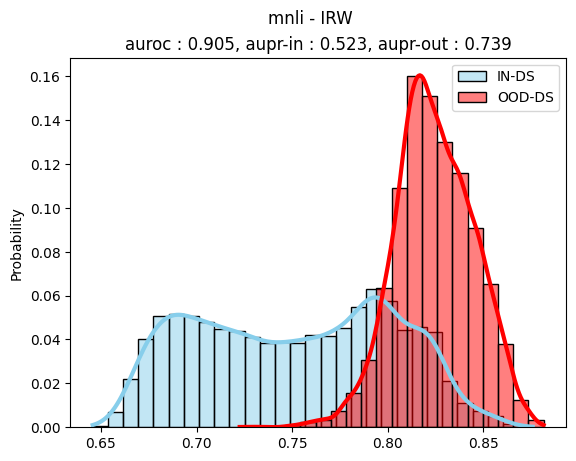

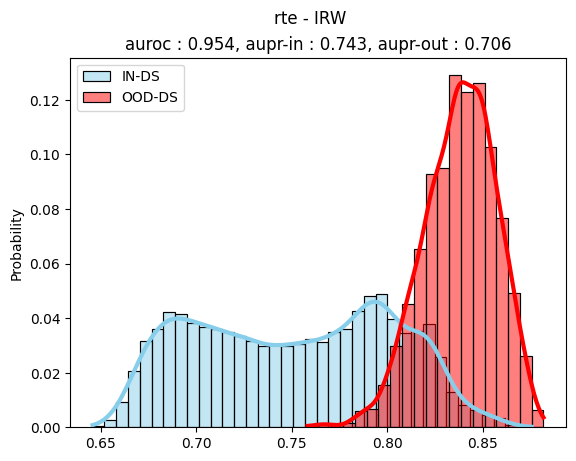

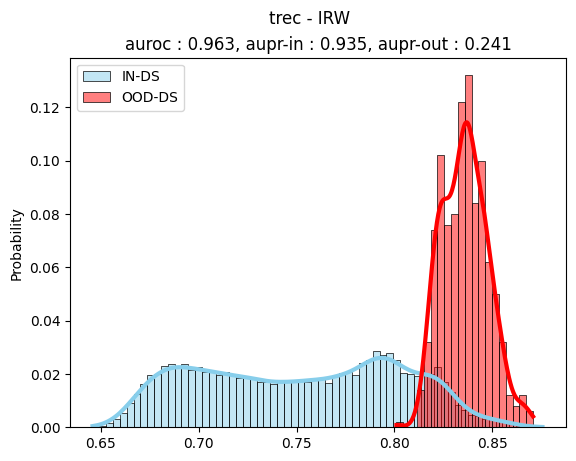

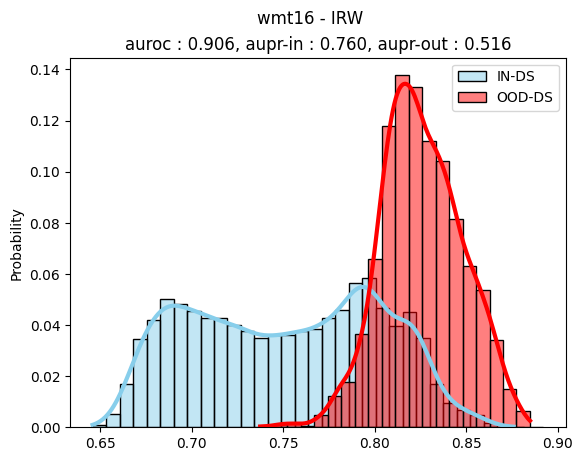

In [17]:
plot_score_distrib_prediction_dependant('IRW',aggregation_function=keep_logits, use_AI_IRW=False)

In [54]:
!pip install pot
import ot

Defaulting to user installation because normal site-packages is not writeable
